In [1]:
import numpy as np
import h5py
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import yaml
import argparse
import xml.etree.ElementTree as ET

sys.path.append('../')
import utils
import settings
plt.style.use('../spectrum.mplstyle')

In [2]:
log_filter = np.array([x.endswith("log") for x in os.listdir()])
log_files = np.array(os.listdir())[log_filter]
print(log_files)
chosen_values = {
    'isosinglet S=0 P=(0,0,0) T1g ROT 0': {"tmin":2,"confidence":1},
    'isosinglet S=0 P=(0,0,0) T1g ROT 1': {"tmin":2,"confidence":1},
    'isosinglet S=0 P=(0,0,0) T1g ROT 2': {"tmin":2,"confidence":1},
    'isosinglet S=0 P=(0,0,0) T1g ROT 3': {"tmin":2,"confidence":1},
    'isosinglet S=0 P=(0,0,0) T1g ROT 4': {"tmin":2,"confidence":1},
    'isosinglet S=0 P=(0,0,0) T1g ROT 5': {"tmin":2,"confidence":1},
    'isosinglet S=0 P=(0,0,0) T1g ROT 6': {"tmin":2,"confidence":1},
}

['isosinglet_nonstrange_nucleonnucleon_sim.isosinglet_S0_T1g_P0_single_pivot_n4_m4_d10_c150.log']


In [3]:
f = plt.figure(facecolor="white")
f.set_figwidth(16)
f.set_figheight(8)
completed_ops = []
for log_file in log_files:
    data = ET.parse(log_file)
    root = data.getroot()
    for item in root.findall('./Task/DoFit'):
        if (item.find("./Type").text=="TemporalCorrelatorTminVary") and (item.find("./TemporalCorrelatorTminVaryFit/Model").text=="TimeForwardThreeIndExp"):
            plt.clf()
            corr = item.find('./TemporalCorrelatorTminVaryFit/GIOperatorString').text
            if corr not in completed_ops:
                print(corr)
                tmin_vals = []
                E1_vals = []
                E0_vals = []
                E2_vals = []
                E1_errs = []
                E0_errs = []
                E2_errs = []
                all_fits = item.findall("./")
                
                while all_fits:
                    while all_fits[0].tag!="TemporalCorrelatorTminVaryFit":
                        all_fits.pop(0)
                        if not all_fits:
                            break
                    if len(all_fits)<=1:
                        break
                    while all_fits[1].tag!="BestFitResult" and all_fits[1].tag!="TemporalCorrelatorTminVaryFit":
                        all_fits.pop(1)
                        if len(all_fits)<=1:
                            break
                    
                    if len(all_fits)<=1:
                        break
                    if all_fits[1].tag=="BestFitResult":
                        tmin_vals.append( int(all_fits[0].find("./TimeSeparations").text.split(" ")[0]) )
                        these_Es = {}
                        these_Es[float(all_fits[1].find("./FitParameter0/MCEstimate/FullEstimate").text)] = 0 
                        these_Es[float(all_fits[1].find("./FitParameter2/MCEstimate/FullEstimate").text)] = 2
                        these_Es[float(all_fits[1].find("./FitParameter4/MCEstimate/FullEstimate").text)] = 4
                        these_Es_sort = list(these_Es.keys())
                        these_Es_sort.sort()
#                         these_Es_sort = {x:i for i,x in enumerate(these_Es_sort)}
                        E0_vals.append( these_Es_sort[0] )
                        E0_errs.append( float(all_fits[1].find(f"./FitParameter{these_Es[these_Es_sort[0]]}/MCEstimate/SymmetricError").text) )
                        E1_vals.append( these_Es_sort[1] )
                        E1_errs.append( float(all_fits[1].find(f"./FitParameter{these_Es[these_Es_sort[1]]}/MCEstimate/SymmetricError").text) )
                        E2_vals.append( these_Es_sort[2] )
                        E2_errs.append( float(all_fits[1].find(f"./FitParameter{these_Es[these_Es_sort[2]]}/MCEstimate/SymmetricError").text) )
                        all_fits.pop(0)
                        all_fits.pop(0)
                    else:
                        all_fits.pop(0)
                        
                        
                f.suptitle(corr)
                plt.subplot(1,2,1)
                plt.errorbar( tmin_vals, E0_vals,E0_errs,marker=settings.markers[0],color=settings.colors[0],lw=0.0, elinewidth=2.0, capsize=5.0)
                plt.xlabel( 'tmin')
                plt.xticks(tmin_vals)
                plt.ylabel('E0')
                if corr in chosen_values:
                    chosen_index = tmin_vals.index(chosen_values[corr]["tmin"])
                    print(chosen_index)
                    chosen_values[corr]["E0_val"] = E0_vals[chosen_index]
                    chosen_values[corr]["E0_err"] = E0_errs[chosen_index]
                    chosen_values[corr]["E1_val"] = E1_vals[chosen_index]
                    chosen_values[corr]["E1_err"] = E1_errs[chosen_index]
                    plt.axhline(chosen_values[corr]["E0_val"],color="black")
                    plt.axhline(chosen_values[corr]["E0_val"]+chosen_values[corr]["E0_err"],color="black",ls="--")
                    plt.axhline(chosen_values[corr]["E0_val"]-chosen_values[corr]["E0_err"],color="black",ls="--")
                    
                plt.subplot(1,2,2)
                plt.errorbar( tmin_vals, E1_vals,E1_errs,marker=settings.markers[1],color=settings.colors[1],lw=0.0, elinewidth=2.0, capsize=5.0,label="E1")
                plt.errorbar( tmin_vals, E2_vals,E2_errs,marker=settings.markers[2],color=settings.colors[2],lw=0.0, elinewidth=2.0, capsize=5.0,label="E2")
                plt.xlabel( 'tmin')
                plt.xticks(tmin_vals)
                plt.ylabel('E1/E2')
                if corr in chosen_values:
                    plt.axhline(chosen_values[corr]["E1_val"],color="black")
                    plt.axhline(chosen_values[corr]["E1_val"]+chosen_values[corr]["E1_err"],color="black",ls="--")
                    plt.axhline(chosen_values[corr]["E1_val"]-chosen_values[corr]["E1_err"],color="black",ls="--")
#                 plt.tight_layout()
                plt.savefig(corr.replace(" ","_")+"_Efits.png")
                completed_ops.append(corr)
                

isosinglet S=0 P=(0,0,0) T1g ROT 0
0
isosinglet S=0 P=(0,0,0) T1g ROT 1
0
isosinglet S=0 P=(0,0,0) T1g ROT 2
0
isosinglet S=0 P=(0,0,0) T1g ROT 3
0
isosinglet S=0 P=(0,0,0) T1g ROT 4
0
isosinglet S=0 P=(0,0,0) T1g ROT 5
0
isosinglet S=0 P=(0,0,0) T1g ROT 6
0
isosinglet S=0 P=(0,0,0) T1g ROT 7


<Figure size 1152x576 with 0 Axes>

In [4]:
E0_vals = [chosen_values[corr]["E0_val"] for corr in chosen_values.keys()]
E0_vals.sort()
sort_order_dict = {x: i for i, x in enumerate(E0_vals)}
# keys = list(chosen_values.keys())
for corr in chosen_values.keys():
    chosen_values[corr]["new_level"] = sort_order_dict[chosen_values[corr]["E0_val"]]


isosinglet S=0 P=(0,0,0) T1g ROT 0 0.662035038641
isosinglet S=0 P=(0,0,0) T1g ROT 1 0.755269310047
isosinglet S=0 P=(0,0,0) T1g ROT 2 0.700244078696
isosinglet S=0 P=(0,0,0) T1g ROT 3 0.725797413825
isosinglet S=0 P=(0,0,0) T1g ROT 4 0.727824200472
isosinglet S=0 P=(0,0,0) T1g ROT 5 0.731220179133
isosinglet S=0 P=(0,0,0) T1g ROT 6 0.749625275656


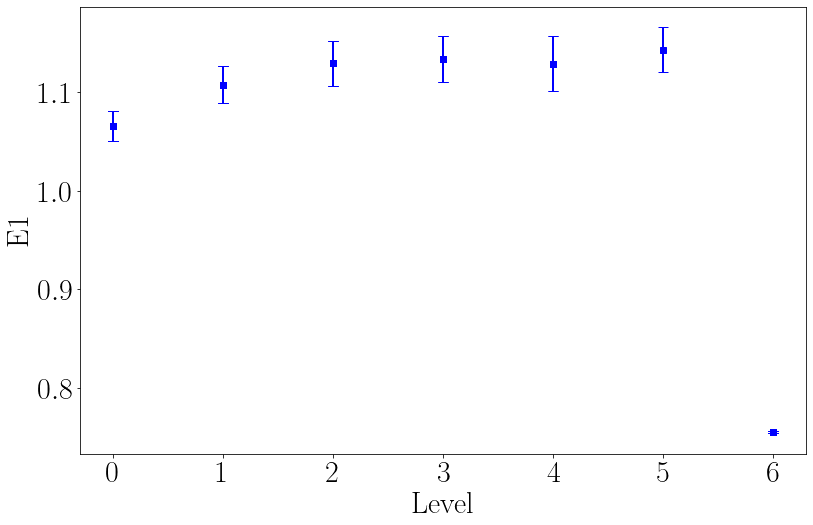

In [5]:
f = plt.figure(facecolor="white")
f.set_figwidth(12)
f.set_figheight(8)
x = []
y = []
yerr = []
for corr in chosen_values.keys():
    if chosen_values[corr]["confidence"]:
        x.append(chosen_values[corr]["new_level"])
        y.append(chosen_values[corr]["E1_val"])
        yerr.append(chosen_values[corr]["E1_err"])
        plt.errorbar( x, y,yerr,marker=settings.markers[1],color=settings.colors[1],lw=0.0, elinewidth=2.0, capsize=5.0)
        plt.xlabel( 'Level')
        plt.xticks(x)
        plt.ylabel('E1')
        plt.tight_layout()
        print( corr, chosen_values[corr]["E0_val"])